In [24]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers
from ast import literal_eval
from gensim.models import KeyedVectors
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

The RNN training parts of this notebook are based on the following:

https://medium.com/@claude.feldges/text-classification-with-tf-idf-lstm-bert-a-quantitative-comparison-b8409b556cb3

In [25]:
### functions

sns.set(font_scale=1.1)

RANDOM_STATE = 12345

def evaluate_classifier(y_test, pred, labels=None):

    fig, ax = plt.subplots(figsize=(8,6))
    # normalize : {'true', 'pred', 'all'}, default=None
    # Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. 
    # If None, confusion matrix will not be normalized.
    cm = confusion_matrix(y_test, pred, normalize=None) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax)
    plt.grid(False)
    plt.show()
    
    print("Accuracy  = " + str(accuracy_score(y_true=y_test, y_pred=pred)))
    print("F1 score  = " + str(f1_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Precision = " + str(precision_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Recall    = " + str(recall_score(y_true=y_test, y_pred=pred, average='weighted')))

In [26]:
df_train = pd.read_csv('../../data/train_data.csv')
df_train['lemmatized'] = df_train['lemmatized'].apply(literal_eval)

df_test = pd.read_csv('../../data/test_data.csv')
df_test['lemmatized'] = df_test['lemmatized'].apply(literal_eval)

df_train.head()

,filename,artist,title,genre,lyrics,instrumental,tokenized,lemmatized
0,country.00041.wav,Johnny Cash,Goin' By The Book,country,\nYou can see it in the movies and the paper a...,False,"['see', 'movies', 'paper', 'tv', 'news', 'some...","[see, movie, paper, tv, news, somebody, army, ..."
1,reggae.00038.wav,Burning Spear,Investigation Dub,reggae,I and I old I know\nI and I old I say\nI and I...,False,"['old', 'know', 'old', 'say', 'reconsider', 's...","[old, know, old, say, reconsider, see, upfully..."
2,disco.00070.wav,KC and The Sunshine Band,That's The Way (I Like It),disco,"That's the way, aha, aha\nI like it, aha, aha\...",False,"['thats', 'way', 'aha', 'aha', 'like', 'aha', ...","[thats, way, aha, aha, like, aha, aha, thats, ..."
3,reggae.00088.wav,Marcia Griffiths,Electric Boogie,reggae,\nIt's electric!\n\n\nYou can't see it\nIt's e...,False,"['electric', 'cant', 'see', 'electric', 'got',...","[electric, cant, see, electric, get, ta, feel,..."
4,pop.00017.wav,Britney Spears,(I Can't Get No) Satisfaction,pop,\nI can't get no satisfaction\nI can't get no ...,False,"['cant', 'get', 'satisfaction', 'cant', 'get',...","[cant, get, satisfaction, cant, get, satisfact..."


In [27]:
num_feats = pd.read_csv('../../data/features_30_sec.csv')
num_feats = num_feats.drop(columns=['length', 'label'])
num_feats

,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,blues.00000.wav,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,blues.00001.wav,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,blues.00002.wav,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,blues.00003.wav,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,blues.00004.wav,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,...,1.789867,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665
996,rock.00096.wav,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,...,3.739020,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624
997,rock.00097.wav,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,...,1.838090,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515
998,rock.00098.wav,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,...,-2.812176,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088


In [28]:
train_num_feats = pd.merge(num_feats, df_train['filename'], how="inner", on="filename")
test_num_feats = pd.merge(num_feats, df_test['filename'], how="inner", on="filename")
assert len(df_train) == len(train_num_feats)
assert len(df_test) == len(test_num_feats)

In [29]:
# word vectors of the following dimensions are available: 50d, 100d, 200d, 300d 
GLOVE_MODELS = {}

for dim in ["100d", "300d"]:#["50d", "100d", "200d", "300d"]:
    glove_path = f"../../glove/glove.6B.{dim}.txt"
    glove_word2vec_path = glove_path + '.word2vec'

    if os.path.exists(glove_word2vec_path):
        # load the Stanford GloVe model
        print(f"Loading saved glove word2vec {dim} model")
        GLOVE_MODELS[dim] = KeyedVectors.load_word2vec_format(glove_word2vec_path, binary=False)
    else:
        # load the Stanford GloVe model from txt file, convert to word2vec and save
        print(f"Creating glove word2vec {dim} model")
        glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
        glove_model.save_word2vec_format(glove_word2vec_path)
        GLOVE_MODELS[dim] = glove_model

print(GLOVE_MODELS)

Loading saved glove word2vec 100d model
Loading saved glove word2vec 300d model
{'100d': <gensim.models.keyedvectors.KeyedVectors object at 0x7f92b0915df0>, '300d': <gensim.models.keyedvectors.KeyedVectors object at 0x7f92b0915790>}


In [30]:
from sklearn.preprocessing import LabelBinarizer

# Renaming, Input -> X, Output -> y
#X_tf_train = df_train['lyrics']
#X_tf_test = df_test['lyrics']
X_tf_train = df_train['lemmatized'].apply(' '.join)
X_tf_test = df_test['lemmatized'].apply(' '.join)

# Convert labels into a one-hot vector (length = number of genres)
lab = LabelBinarizer()
lab.fit(df_train['genre'])
y_tf_train = lab.transform(df_train['genre'])
y_tf_test = lab.transform(df_test['genre'])

# Example (you can modify n)
print('Coding of labels into a one-hot vector, e.g.: ')
print(df_train['genre'][0], '->', y_tf_train[0])
print(df_train['genre'][1], ' ->', y_tf_train[1])
print(df_train['genre'][2], '  ->', y_tf_train[2])

Coding of labels into a one-hot vector, e.g.: 
country -> [0 1 0 0 0 0 0 0]
reggae  -> [0 0 0 0 0 0 1 0]
disco   -> [0 0 1 0 0 0 0 0]


In [31]:
corpus = X_tf_train
max_words = 20000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [157]:
max_len = 200

sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)

n=0 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print('Example: ',X_tf_train_seq[n,:])

Shape:  (609, 200)
Example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   24  873 1563 1022  758  328 4351   90   81  114   11 1083  299
 1431    2 4352 2552 1150   35   11  617  509  136  315 4353  265  114
  269  269 1902  269 1023  114 2163  268  153 1564   40  273  140   22
  492   77  155  395  239  431   76   13  316   27  136   69   14 1903
  493  557  396 1432  420   30   41   31   66  470  283   24   11 1151
  114 4354  329 3143   59   82 1565 1566 1235  220   10  246  558   26
 2163 4355   10  874    2  252 2553    2   82  4

In [158]:
glove = GLOVE_MODELS["100d"]
corpus_len = len(reverse_voc)
emb_matrix=np.zeros((corpus_len+1, glove.vector_size))

for i in range(corpus_len):
    w = reverse_voc[i+1]
    try:
        # throws KeyError if word not found
        #word_embed = 
        emb_matrix[i+1,:] = glove.get_vector(w)
    except KeyError:
        pass
    
emb_size = emb_matrix.shape[1]
print(emb_matrix.shape)

(7660, 100)


In [159]:
X_train_num = train_num_feats.drop(columns=['filename']).to_numpy(dtype='float')
X_test_num = test_num_feats.drop(columns=['filename']).to_numpy(dtype='float')

scale = StandardScaler()
scale.fit(X_train_num)
X_train_num = scale.transform(X_train_num)
X_test_num = scale.transform(X_test_num)

print(X_train_num.shape)

(609, 57)


In [169]:
text_input_ = layers.Input(shape = X_tf_train_seq[0,:].shape, name='text_input')
num_input_ = layers.Input(shape = X_train_num[0,:].shape, name='numerical_input')

# Embedding layer (voc size plus pad token (with index 0), using the pre-trained emb_matrix obtained from glove
x = layers.Embedding(corpus_len+1, emb_size, weights=[emb_matrix], trainable=False, name='embedding')(text_input_)
x = layers.Bidirectional(layers.LSTM(64,dropout=0.2), name='bidirectional-lstm2')(x) # LSTM layer
x2 = layers.Concatenate(name='concatenate')([x, num_input_])
x2 = layers.Dropout(0.2, name='dropout')(x2)
x2 = layers.Dense(128, activation='relu', name='dense1')(x2)
output = layers.Dense(df_train['genre'].nunique(), activation='softmax', name='classification')(x2)

model = models.Model([text_input_, num_input_], output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [170]:
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 100)     766000      ['text_input[0][0]']             
                                                                                                  
 bidirectional-lstm2 (Bidirecti  (None, 128)         84480       ['embedding[0][0]']              
 onal)                                                                                            
                                                                                                  
 numerical_input (InputLayer)   [(None, 57)]         0           []                        

In [172]:
start_time = datetime.now()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="concat_model/{val_accuracy:.3f}_acc",
    monitor='val_accuracy',
    mode='max',
    save_weights_only=False,
    save_best_only=True)

history = model.fit([X_tf_train_seq, X_train_num], y_tf_train, batch_size=16, shuffle=True, epochs=20, callbacks=[checkpoint_cb], validation_data=([X_tf_test_seq, X_test_num], y_tf_test))
end_time = datetime.now()

training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/20
39/39 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.8309

INFO:tensorflow:Assets written to: concat_model2/0.307_acc/assets


INFO:tensorflow:Assets written to: concat_model2/0.307_acc/assets


39/39 [==============================] - 12s 313ms/step - loss: 0.5033 - accuracy: 0.8309 - val_loss: 4.0493 - val_accuracy: 0.3072
Epoch 2/20
39/39 [==============================] - 3s 77ms/step - loss: 0.4610 - accuracy: 0.8506 - val_loss: 3.9599 - val_accuracy: 0.3072
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.8440

INFO:tensorflow:Assets written to: concat_model2/0.333_acc/assets


INFO:tensorflow:Assets written to: concat_model2/0.333_acc/assets


39/39 [==============================] - 10s 267ms/step - loss: 0.4490 - accuracy: 0.8440 - val_loss: 4.2761 - val_accuracy: 0.3333
Epoch 4/20
39/39 [==============================] - 3s 77ms/step - loss: 0.4761 - accuracy: 0.8522 - val_loss: 3.8521 - val_accuracy: 0.3137
Epoch 5/20
39/39 [==============================] - 3s 74ms/step - loss: 0.2938 - accuracy: 0.8966 - val_loss: 4.3521 - val_accuracy: 0.3137
Epoch 6/20
39/39 [==============================] - 3s 81ms/step - loss: 0.2732 - accuracy: 0.9163 - val_loss: 4.8116 - val_accuracy: 0.2876
Epoch 7/20
39/39 [==============================] - 4s 97ms/step - loss: 0.3193 - accuracy: 0.8982 - val_loss: 4.9937 - val_accuracy: 0.2941
Epoch 8/20
39/39 [==============================] - 5s 120ms/step - loss: 0.3326 - accuracy: 0.8982 - val_loss: 4.7839 - val_accuracy: 0.3137
Epoch 9/20
39/39 [==============================] - 4s 107ms/step - loss: 0.2448 - accuracy: 0.9130 - val_loss: 4.5766 - val_accuracy: 0.3203
Epoch 10/20
39/39 [=

INFO:tensorflow:Assets written to: concat_model2/0.340_acc/assets


INFO:tensorflow:Assets written to: concat_model2/0.340_acc/assets


39/39 [==============================] - 13s 335ms/step - loss: 0.2031 - accuracy: 0.9310 - val_loss: 5.1296 - val_accuracy: 0.3399
Epoch 13/20
39/39 [==============================] - 3s 81ms/step - loss: 0.1439 - accuracy: 0.9507 - val_loss: 5.2191 - val_accuracy: 0.3007
Epoch 14/20
39/39 [==============================] - 4s 103ms/step - loss: 0.2791 - accuracy: 0.9245 - val_loss: 4.9217 - val_accuracy: 0.3268
Epoch 15/20
39/39 [==============================] - 4s 94ms/step - loss: 0.1457 - accuracy: 0.9524 - val_loss: 4.7878 - val_accuracy: 0.2941
Epoch 16/20
39/39 [==============================] - 4s 101ms/step - loss: 0.1672 - accuracy: 0.9360 - val_loss: 5.2666 - val_accuracy: 0.3333
Epoch 17/20
39/39 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.9475

INFO:tensorflow:Assets written to: concat_model2/0.366_acc/assets


INFO:tensorflow:Assets written to: concat_model2/0.366_acc/assets


39/39 [==============================] - 13s 335ms/step - loss: 0.1646 - accuracy: 0.9475 - val_loss: 5.3015 - val_accuracy: 0.3660
Epoch 18/20
39/39 [==============================] - 3s 80ms/step - loss: 0.1851 - accuracy: 0.9425 - val_loss: 5.6316 - val_accuracy: 0.2876
Epoch 19/20
39/39 [==============================] - 4s 95ms/step - loss: 0.2158 - accuracy: 0.9409 - val_loss: 5.4098 - val_accuracy: 0.2941
Epoch 20/20
39/39 [==============================] - 4s 101ms/step - loss: 0.4211 - accuracy: 0.8966 - val_loss: 5.2833 - val_accuracy: 0.3137



Best Accuracy Training data:  99.84%
Best Accuracy Test data:      45.10%
Training time: 214.9 sec


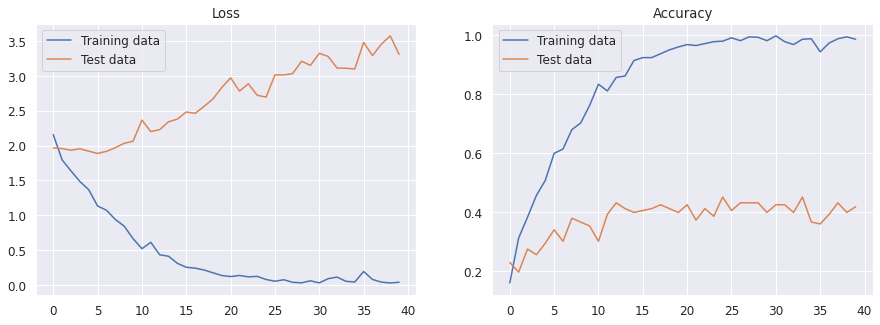

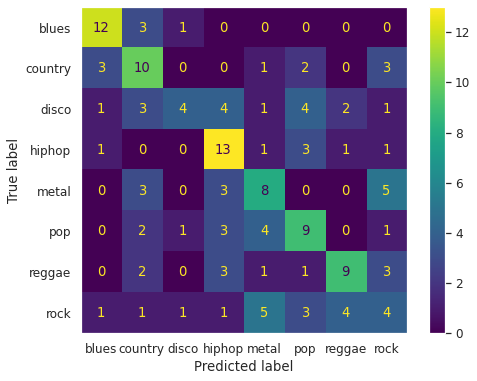

Accuracy  = 0.45098039215686275
F1 score  = 0.43970239294896074
Precision = 0.4587803415417795
Recall    = 0.45098039215686275


In [168]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training data')
ax[0].plot(history.history['val_loss'], label='Test data')
ax[0].legend(loc="upper left")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training data')
ax[1].plot(history.history['val_accuracy'], label='Test data')
ax[1].legend(loc="upper left")

print("")
accuracy_rnn = history.history['val_accuracy'][-1]
print('Best Accuracy Training data:  {:.2%}'.format(max(history.history['accuracy'])))
print('Best Accuracy Test data:      {:.2%}'.format(max(history.history['val_accuracy'])))
print('Training time: {:.1f} sec'.format(training_time_rnn))

best = sorted(os.listdir("concat_model/"))[-1]
best_model = tf.keras.models.load_model(f"concat_model/{best}")
pred_prob = best_model.predict([X_tf_test_seq, X_test_num])
pred = np.argmax(pred_prob, axis=1)
pred = lab.classes_[pred].tolist()
evaluate_classifier(df_test['genre'], pred, lab.classes_)


Best Accuracy Training data:  99.34%
Best Accuracy Test data:      45.75%
Training time: 111.2 sec


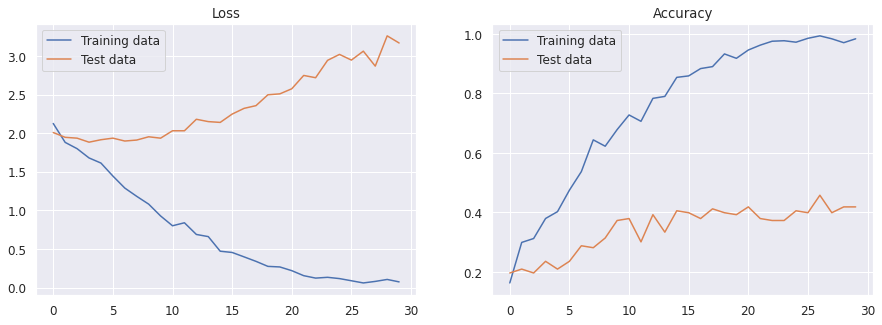

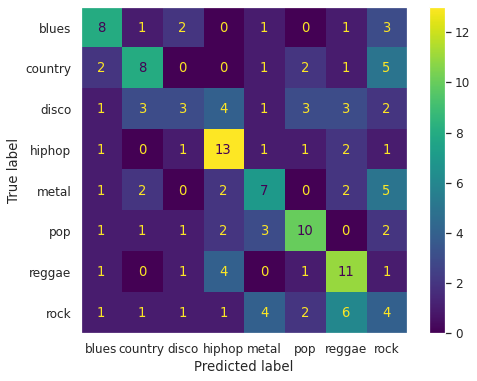

Accuracy  = 0.41830065359477125
F1 score  = 0.409041906623075
Precision = 0.41567708335330716
Recall    = 0.41830065359477125


In [146]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training data')
ax[0].plot(history.history['val_loss'], label='Test data')
ax[0].legend(loc="upper left")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training data')
ax[1].plot(history.history['val_accuracy'], label='Test data')
ax[1].legend(loc="upper left")

print("")
accuracy_rnn = history.history['val_accuracy'][-1]
print('Best Accuracy Training data:  {:.2%}'.format(max(history.history['accuracy'])))
print('Best Accuracy Test data:      {:.2%}'.format(max(history.history['val_accuracy'])))
print('Training time: {:.1f} sec'.format(training_time_rnn))

pred_prob = model.predict([X_tf_test_seq, X_test_num])
pred = np.argmax(pred_prob, axis=1)
pred = lab.classes_[pred].tolist()
evaluate_classifier(df_test['genre'], pred, lab.classes_)